## Homework 6, Problem 3 on Wiener filter

ECE C143A/C243A, Spring Quarter 2018, Prof. J.C. Kao, TAs T. Monsoor, X. Jiang and X. Yang.

Total: 15 points. In this notebook, you will implement an optimal linear estimator decoder.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.io as sio
import math
import nsp as nsp
# Load matplotlib images inline
%matplotlib inline
# Reloading any code written in external .py files.
%load_ext autoreload
%autoreload 2
data = sio.loadmat('JR_2015-12-04_truncated2.mat') # load the .mat file.
R = data['R'][0,:]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### (a) (4 points) Preparing training data for a Wiener filter.  [Code solution provided; please understand it and answer the question.]

Now that we’ve built an optimal linear estimator, we’ll extend it to incorporate history. We will train a Wiener filter, again using just the first 400 trials of the R-struct. We will use 100 ms worth of history in our Wiener filter. As each bin is 25 ms long, this corresponds to using data up to and including 4 bins in the past, i.e. $P=3$. Make the large matrix $Y_W$ discussed in Lecture. To be clear, we are talking about the matrix:
\begin{bmatrix}
    y_{P+1}       & y_{P+2} & y_{P+3} & \dots & y_{K} \\
    y_{P}       & y_{P+1} & y_{P+2} & \dots & y_{K-1} \\
    \dots \\
    y_{1}       & y_{2} & y_{3} & \dots & y_{K-P}\\
    1       & 1 & 1 & \dots & 1\\
\end{bmatrix}
Calculate this matrix and output its dimension.

In [17]:
dt = 25
train_num = 400
Y =scipy.sparse.hstack(R[0:train_num]['spikeRaster'])
X =scipy.sparse.hstack(R[0:train_num]['cursorPos'])
X= scipy.sparse.csc_matrix(X)
Y_bin = nsp.bin(Y, dt,'sum')
X_bin = nsp.bin(X, dt,'first')
X_bin = np.diff(X_bin[0:2,:])/dt*1000
X_small_bin = np.matrix(X_bin[:,3:],dtype=float)
last_index = np.size(X_bin,1)
Y1= np.matrix(Y_bin[:,3:],dtype= float)
Y2 =np.matrix(Y_bin[:,2:-1],dtype= float)
Y3 =np.matrix(Y_bin[:,1:-2],dtype= float)
Y4 =np.matrix(Y_bin[:,0:-3],dtype= float)
Y_large = np.vstack((Y1,Y2,Y3,Y4))
Y_w_bin = np.vstack((Y_large,np.ones(np.size(Y_large,1))))
print("The dimension for the large matrix",np.size(Y_w_bin,0),np.size(Y_w_bin,1))   

The dimension for the large matrix 385 16462


Question: What are the dimensions of $Y_W$?

Answer: 
385 x 16462;   385=96*4+1;   Since P = 3. 16462 = number of bins -3
        

### (b) (7 points)  Fit a Wiener filter and decode activity.

Fit the Wiener filter using the data matrix you generated in part(a). Plot, as you did in question 2(g), the decoded trajectories for each test trial. (Hint: to decode the first 3 velocities of trial i at times 25 ms, 50 ms, and 75 ms, since 100 ms have not yet occurred in the trial, you will have to use the last bins of spiking activity in trial $i−1$.)


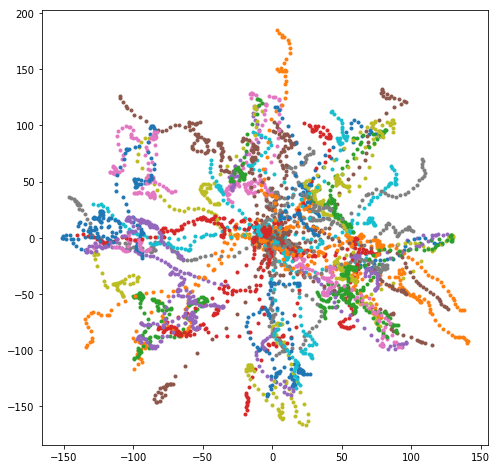

In [18]:
plt.figure(figsize=(8,8))
L = np.matmul(X_bin[:,3:].astype('float'),scipy.linalg.pinv(Y_w_bin.astype('float')))
for i in range(400,506):
    Y_bin = nsp.bin(R[i]['spikeRaster'], dt,'sum')
    Y_1bin = nsp.bin(R[i-1]['spikeRaster'], dt,'sum')
    Y1 = np.matrix(Y_bin,dtype= float)
    Y2 = np.matrix(Y_bin[:,:-1],dtype= float)
    Y3 = np.matrix(Y_bin[:,:-2],dtype= float)
    Y4 = np.matrix(Y_bin[:,:-3],dtype= float)
    Y21 = np.matrix(Y_1bin[:,-1:],dtype= float)
    Y31 = np.matrix(Y_1bin[:,-2:],dtype= float)
    Y41 = np.matrix(Y_1bin[:,-3:],dtype= float)
    Y2 = np.hstack((Y21,Y2))
    Y3 = np.hstack((Y31,Y3))
    Y4 = np.hstack((Y41,Y4))
    Y_large = np.vstack((Y1,Y2,Y3,Y4))
    Y_bin = np.vstack((Y_large,np.ones(np.size(Y_large,1))))
    X_test = np.array(np.matmul(L,Y_bin))
    pos = np.zeros([2,X_test.shape[1]+1])
    pos[:,0] = R[i]['cursorPos'][:2,0]
    for j in range(X_test.shape[1]):
        pos[:,j+1] = pos[:,j] + X_test[:,j]*0.025
    plt.plot(pos[0,:],pos[1,:],'.')   
plt.show()

### (c) (4 points) Calculate the mean-square error for the Wiener filter.

What is the average mean-square error in position per trial? Did the Wiener filter perform better or worse than the optimal linear estimator?

In [19]:
err = 0
for i in range(400,506):
    Y_bin = nsp.bin(R[i]['spikeRaster'], dt,'sum')
    X_bin = nsp.bin(R[i]['cursorPos'], dt,'last')[:2,]
    Y_1bin = nsp.bin(R[i-1]['spikeRaster'], dt,'sum')
    Y1 = np.matrix(Y_bin,dtype= float)
    Y2 = np.matrix(Y_bin[:,:-1],dtype= float)
    Y3 = np.matrix(Y_bin[:,:-2],dtype= float)
    Y4 = np.matrix(Y_bin[:,:-3],dtype= float)
    Y21 = np.matrix(Y_1bin[:,-1:],dtype= float)
    Y31 = np.matrix(Y_1bin[:,-2:],dtype= float)
    Y41 = np.matrix(Y_1bin[:,-3:],dtype= float)
    Y2 = np.hstack((Y21,Y2))
    Y3 = np.hstack((Y31,Y3))
    Y4 = np.hstack((Y41,Y4))
    
    Y_large = np.vstack((Y1,Y2,Y3,Y4))

    Y_bin = np.vstack((Y_large,np.ones(np.size(Y_large,1))))
    X_test = np.array(np.matmul(L,Y_bin))
    
    pos = np.zeros([2,X_test.shape[1]+1])
    pos[:,0] = R[i]['cursorPos'][:2,0]
    error = 0
    for j in range(X_test.shape[1]):
        pos[:,j+1] = pos[:,j] + X_test[:,j]*0.025
        error += (np.linalg.norm(pos[:,j+1]-X_bin[:,j]))**2
    error /= X_bin.shape[1]
    err += error
err /= 106
print(err)

3343.90261856


Question: Does the WF do better or worse than the OLE?

Answer:Yes WF only has error 3343, OLE has 5471